# Weather Data Processing & Masterset Creation

**Project:** Electricity Price Forecasting
**Stage:** Data Engineering (Track B & Convergence)

**Objective:**
This notebook implements the second half of the data engineering pipeline. It processes the raw gridded weather data (ERA5) and merges it with the clean electricity price data (ENTSO-E) to create the final "Masterset" for modeling.

**Methodology:**
1.  **Weather Track (ERA5):**
    * Input: Raw NetCDF files (Spatial Grids).
    * Processing: Calculate **Zonal Spatial Mean** for all variables (Temperature, Wind, Solar, Precipitation).
    * Feature Engineering: Calculate Wind Speed magnitude from U/V components.
2.  **Price Track (ENTSO-E):**
    * Input: Preprocessed CSVs (Wide Format).
    * Processing: Reshape to Long Format and synchronize Timezones (UTC).
3.  **Convergence:**
    * Merge both streams on an exact UTC timestamp index.
    * Save final datasets for Clustering and Forecasting.

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from pathlib import Path
import warnings

# Suppress specific pandas warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)

# ==========================================
# 1. PATH CONFIGURATION
# ==========================================
# Define project root relative to this notebook
DATA_DIR = Path('../../data')

# Input Paths
RAW_WEATHER_DIR = DATA_DIR / 'raw' / 'weather'
PRICE_CLEAN_DIR = Path('data/clean') # Local folder in this directory

# Output Path
OUTPUT_DIR = DATA_DIR / 'processed'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ==========================================
# 2. RUN CONFIGURATION
# ==========================================
# Zones to process sequentially
ZONES_TO_PROCESS = ['DK1', 'NO2', 'ES']

# Years to include in the masterset (Weather data availability)
YEARS = [2023, 2024, 2025]

print(f"Configuration Loaded.")
print(f"Input Weather: {RAW_WEATHER_DIR.resolve()}")
print(f"Input Prices:  {PRICE_CLEAN_DIR.resolve()}")
print(f"Output Target: {OUTPUT_DIR.resolve()}")

Configuration Loaded.
Input Weather: C:\Users\maxim\Projects\DsLab25W_marbl.energy\data\raw\weather
Input Prices:  C:\Users\maxim\Projects\DsLab25W_marbl.energy\notebooks\02_preprocessing\data\clean
Output Target: C:\Users\maxim\Projects\DsLab25W_marbl.energy\data\processed


## Track B: Weather Data Processing (ERA5)

This function handles the complexity of multidimensional NetCDF files.

**Key Operations:**
1.  **Spatial Aggregation:** We calculate the mean of all grid points within the file (`ds.mean`). This represents the aggregate weather condition for the entire bidding zone.
2.  **Variable Standardization:**
    * **Wind Speed:** Calculated from U-component and V-component vectors ($\sqrt{u^2 + v^2}$) if pre-calculated speed is missing.
    * **Temperature:** Converted from Kelvin to Celsius.
    * **Precipitation:** Converted from meters to millimeters.
    * **Solar Radiation:** Converted from Joules ($J/m^2$) to Power ($W/m^2$).
3.  **Timezone:** Ensures the index is strict UTC.

In [2]:
def process_era5_netcdf(zone, years):
    print(f"  > Processing ERA5 NetCDF for {zone}...")
    all_hourly_data = []

    for year in years:
        for month in range(1, 13):
            month_str = f"{month:02d}"
            
            # Construct file paths
            path_instant = RAW_WEATHER_DIR / f"era5_{zone}_{year}_{month_str}_instant.nc"
            path_accum = RAW_WEATHER_DIR / f"era5_{zone}_{year}_{month_str}_accum.nc"
            
            # Skip if files are missing (e.g. future months)
            if not path_instant.exists() or not path_accum.exists():
                continue

            try:
                # --- A. Process Instantaneous Variables (Temp, Wind) ---
                ds_inst = xr.open_dataset(path_instant)
                
                # Standardize time dimension name
                if 'valid_time' in ds_inst.coords:
                    ds_inst = ds_inst.rename({'valid_time': 'time'})
                
                # Calculate Spatial Mean (collapse lat/lon)
                df_inst = ds_inst.mean(dim=['latitude', 'longitude']).to_dataframe().reset_index()
                
                # Calculate Wind Speed Magnitude if missing
                if 'si10' not in df_inst.columns:
                    if 'u10' in df_inst.columns and 'v10' in df_inst.columns:
                        df_inst['wind_speed_10m'] = np.sqrt(df_inst['u10']**2 + df_inst['v10']**2)
                    else:
                        df_inst['wind_speed_10m'] = np.nan
                else:
                    df_inst['wind_speed_10m'] = df_inst['si10']

                # Convert Temperature (Kelvin -> Celsius)
                if 't2m' in df_inst.columns:
                    df_inst['temperature_2m'] = df_inst['t2m'] - 273.15
                
                # Select features
                df_inst = df_inst[['time', 'temperature_2m', 'wind_speed_10m']]

                # --- B. Process Accumulated Variables (Precip, Solar) ---
                ds_acc = xr.open_dataset(path_accum)
                
                if 'valid_time' in ds_acc.coords:
                    ds_acc = ds_acc.rename({'valid_time': 'time'})
                    
                df_acc = ds_acc.mean(dim=['latitude', 'longitude']).to_dataframe().reset_index()
                
                # Convert Precipitation (m -> mm)
                df_acc['precipitation_mm'] = df_acc['tp'] * 1000 if 'tp' in df_acc.columns else 0.0
                
                # Convert Solar (Joules -> Watts)
                # Divided by 3600 because ERA5 accumulates over the hour
                df_acc['solar_radiation_W'] = df_acc['ssrd'] / 3600 if 'ssrd' in df_acc.columns else 0.0
                
                df_acc = df_acc[['time', 'precipitation_mm', 'solar_radiation_W']]

                # --- C. Merge Instant and Accum for this month ---
                df_month = pd.merge(df_inst, df_acc, on='time', how='inner')
                all_hourly_data.append(df_month)
                
                # Cleanup
                ds_inst.close()
                ds_acc.close()
                
            except Exception as e:
                print(f"    Error reading {year}-{month_str}: {e}")
                continue

    if not all_hourly_data:
        return pd.DataFrame()
        
    # Combine all months
    df_weather = pd.concat(all_hourly_data, ignore_index=True)
    
    # Finalize Index (UTC)
    df_weather['timestamp'] = pd.to_datetime(df_weather['time'])
    df_weather = df_weather.set_index('timestamp').sort_index()
    df_weather = df_weather.drop(columns=['time'])
    
    # Ensure UTC timezone awareness
    if df_weather.index.tz is None:
        df_weather.index = df_weather.index.tz_localize('UTC')
    else:
        df_weather.index = df_weather.index.tz_convert('UTC')
        
    return df_weather

## Track A: Price Data Preparation (ENTSO-E)

This function prepares the price data for merging.

**Key Operations:**
1.  **Melt:** Transforms the data from Wide format (`date, h00...h23`) back to Long format (`timestamp, price`) required for machine learning.
2.  **DST Handling:** The most critical step. We convert the Local Time (Europe/Vienna) back to UTC.
    * *Ambiguous Times (Fall Back):* Dropped/Handled via NaT to prevent duplicates.
    * *Non-existent Times (Spring Forward):* Dropped via NaT to prevent errors.

In [3]:
def prepare_price_data(zone):
    path = PRICE_CLEAN_DIR / f"{zone}_preprocessed.csv"
    if not path.exists():
        print(f"  Price file not found: {path}")
        return pd.DataFrame()
        
    print(f"  > Loading prices from: {path.name}")
    df_wide = pd.read_csv(path)
    
    # Melt Wide -> Long
    df_long = df_wide.melt(id_vars=['date'], var_name='hour_str', value_name='price_eur_mwh')
    
    # Reconstruct timestamps (Naive first)
    df_long['hour'] = df_long['hour_str'].str.replace('h', '').astype(int)
    df_long['timestamp_naive'] = pd.to_datetime(df_long['date']) + pd.to_timedelta(df_long['hour'], unit='h')
    
    # Set index and sort
    df_long = df_long.set_index('timestamp_naive').sort_index()
    
    # Remove duplicates
    df_long = df_long[~df_long.index.duplicated(keep='first')]

    # Robust DST Conversion (Local -> UTC)
    try:
        # Standard conversion
        df_long.index = df_long.index.tz_localize(
            'Europe/Vienna', 
            ambiguous='infer', 
            nonexistent='shift_forward'
        ).tz_convert('UTC')
        
    except Exception:
        # Fallback for problematic transitions
        # We mark ambiguous/nonexistent times as NaT and drop them
        temp_index = df_long.index.tz_localize(
            'Europe/Vienna', 
            ambiguous='NaT', 
            nonexistent='NaT'
        )
        
        # Drop rows where conversion failed
        df_long = df_long[~temp_index.isna()]
        df_long.index = temp_index[~temp_index.isna()].tz_convert('UTC')

    return df_long[['price_eur_mwh']]

## Execution Loop

We iterate through all configured zones (`DK1`, `NO2`, `ES`).
For each zone, we:
1.  Process Weather (Track B).
2.  Prepare Prices (Track A).
3.  **Merge (Convergence):** Inner join on UTC timestamps. This automatically trims the 10-year price history to match the available 3-year weather history.
4.  **Save:** Export the final `_masterset.csv`.

In [4]:
print("\n" + "="*60)
print("STARTING BATCH PROCESSING")
print("="*60)

for zone in ZONES_TO_PROCESS:
    print(f"\n STARTING ZONE: {zone}")
    
    # 1. Run Weather Track
    df_weather = process_era5_netcdf(zone, YEARS)
    if df_weather.empty:
        print(f"Skipping {zone}: Weather data missing.")
        continue
        
    # 2. Run Price Track
    df_price = prepare_price_data(zone)
    if df_price.empty:
        print(f"Skipping {zone}: Price data missing.")
        continue
        
    # 3. Convergence (Merge)
    # Inner join ensures we only keep rows where we have BOTH price and weather
    df_master = pd.merge(df_price, df_weather, left_index=True, right_index=True, how='inner')
    
    if df_master.empty:
        print(f"Warning: Merge resulted in 0 rows. Check timestamps.")
    else:
        # Final Polish: Convert back to Local Time for interpretation
        df_master.index = df_master.index.tz_convert('Europe/Vienna')
        
        # Save Masterset
        output_path = OUTPUT_DIR / f"{zone}_masterset.csv"
        df_master.to_csv(output_path)
        
        print(f"SUCCESS: Created {output_path.name}")
        print(f"Dimensions: {df_master.shape}")
        print(f"Time Range: {df_master.index.min()} to {df_master.index.max()}")

print("\n" + "="*60)
print("BATCH PROCESSING COMPLETE")


STARTING BATCH PROCESSING

 STARTING ZONE: DK1
  > Processing ERA5 NetCDF for DK1...
  > Loading prices from: DK1_preprocessed.csv
SUCCESS: Created DK1_masterset.csv
Dimensions: (25400, 5)
Time Range: 2023-01-01 01:00:00+01:00 to 2025-11-24 14:00:00+01:00

 STARTING ZONE: NO2
  > Processing ERA5 NetCDF for NO2...
  > Loading prices from: NO2_preprocessed.csv
SUCCESS: Created NO2_masterset.csv
Dimensions: (25457, 5)
Time Range: 2023-01-01 01:00:00+01:00 to 2025-11-26 23:00:00+01:00

 STARTING ZONE: ES
  > Processing ERA5 NetCDF for ES...
  > Loading prices from: ES_preprocessed.csv
SUCCESS: Created ES_masterset.csv
Dimensions: (25457, 5)
Time Range: 2023-01-01 01:00:00+01:00 to 2025-11-26 23:00:00+01:00

BATCH PROCESSING COMPLETE


## Validation: Market Fundamentals Check

We perform a targeted visual inspection based on the primary price driver for each zone:
* **DK1 (Wind Dominated):** Plots **Wind Speed** vs. Price.
* **ES (Solar Dominated):** Plots **Solar Irradiance** vs. Price.
* **NO2 (Hydro/Heating):** Plots **Temperature** vs. Price (Cold weather drives demand/prices up).

Starting Validation Loop...

=== VALIDATION REPORT FOR DK1 ===
Correlations with Price:
wind_speed_10m      -0.438206
solar_radiation_W   -0.315046
temperature_2m      -0.213026
precipitation_mm    -0.197348
Name: price_eur_mwh, dtype: float64


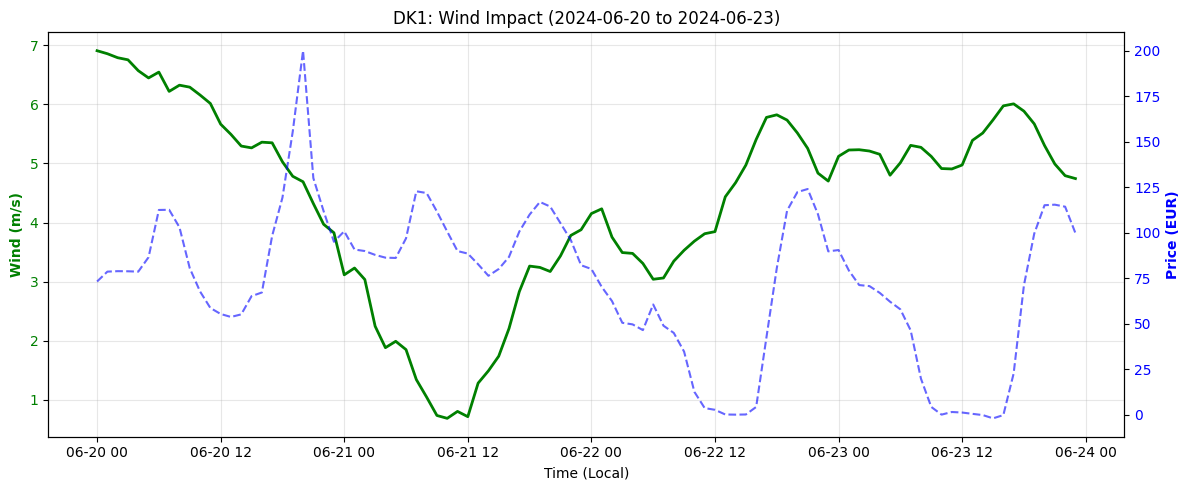

CHECK: Observe the inverse relationship between Wind (m/s) and Price.

SPOT CHECK ROW: 2024-06-13 08:00:00+02:00
------------------------------
Price (ENTSO-E): 106.07 EUR/MWh
Temp (ERA5):     10.27 C
Wind (ERA5):     6.80 m/s
------------------------------



=== VALIDATION REPORT FOR NO2 ===
Correlations with Price:
wind_speed_10m      -0.251863
solar_radiation_W   -0.194742
temperature_2m      -0.348905
precipitation_mm    -0.170242
Name: price_eur_mwh, dtype: float64


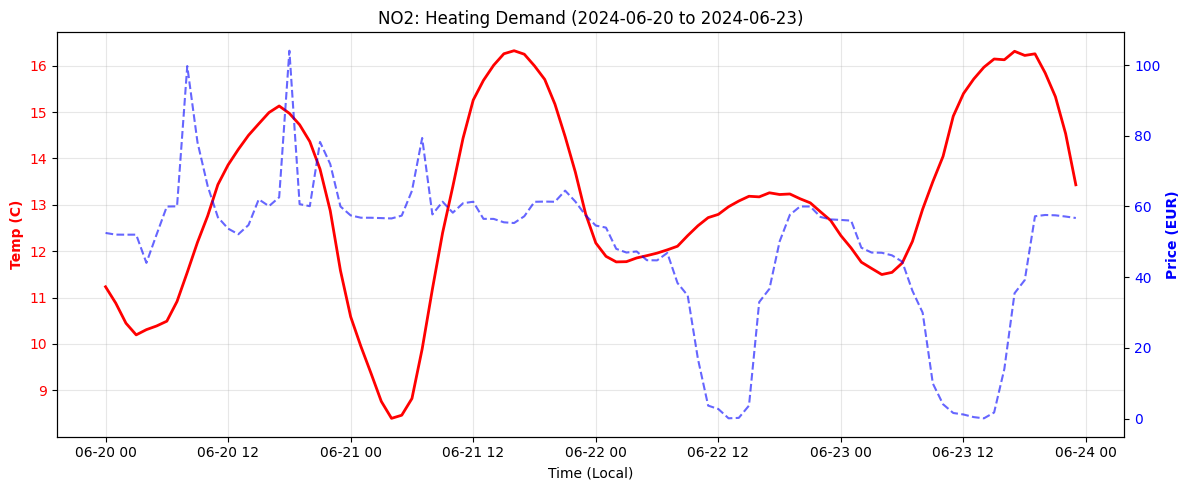

CHECK: Observe the inverse relationship between Temp (C) and Price.

SPOT CHECK ROW: 2024-06-14 12:00:00+02:00
------------------------------
Price (ENTSO-E): 40.96 EUR/MWh
Temp (ERA5):     11.83 C
Wind (ERA5):     5.10 m/s
------------------------------



=== VALIDATION REPORT FOR ES ===
Correlations with Price:
wind_speed_10m      -0.368335
solar_radiation_W   -0.400270
temperature_2m      -0.054361
precipitation_mm    -0.186047
Name: price_eur_mwh, dtype: float64


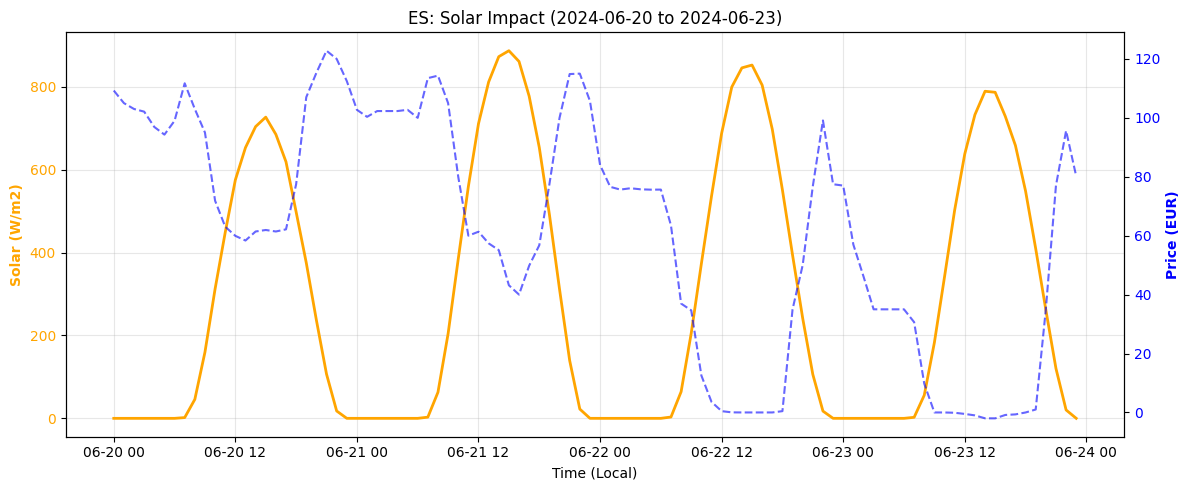

CHECK: Observe the inverse relationship between Solar (W/m2) and Price.

SPOT CHECK ROW: 2024-06-14 12:00:00+02:00
------------------------------
Price (ENTSO-E): 3.25 EUR/MWh
Temp (ERA5):     22.89 C
Wind (ERA5):     1.08 m/s
------------------------------




In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def validate_masterset(zone_name):
    path = OUTPUT_DIR / f"{zone_name}_masterset.csv"
    if not path.exists():
        print(f"Skipping validation: {path} not found.")
        return

    # 1. Load Data
    print(f"\n=== VALIDATION REPORT FOR {zone_name} ===")
    df = pd.read_csv(path, index_col=0)
    
    # Fix Timezone (UTC -> Vienna)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('Europe/Vienna')
    
    # 2. Correlation Check
    if 'price_eur_mwh' in df.columns:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if 'price_eur_mwh' in numeric_cols:
             corr = df[numeric_cols].corr()['price_eur_mwh'].sort_values()
             print("Correlations with Price:")
             target_cols = ['wind_speed_10m', 'solar_radiation_W', 'temperature_2m', 'precipitation_mm']
             present_cols = [c for c in target_cols if c in corr.index]
             print(corr[present_cols])
    
    # 3. Dynamic Plotting Configuration
    # Define which variable to plot for which zone
    plot_config = {
        'DK1': {'col': 'wind_speed_10m', 'color': 'green',  'label': 'Wind (m/s)', 'title': 'Wind Impact'},
        'ES':  {'col': 'solar_radiation_W', 'color': 'orange', 'label': 'Solar (W/m2)', 'title': 'Solar Impact'},
        'NO2': {'col': 'temperature_2m', 'color': 'red',    'label': 'Temp (C)', 'title': 'Heating Demand'},
        # Fallback for unknown zones
        'default': {'col': 'wind_speed_10m', 'color': 'gray', 'label': 'Wind (m/s)', 'title': 'Wind Impact'}
    }
    
    cfg = plot_config.get(zone_name, plot_config['default'])
    
    # Define time window (Summer Solstice is good for Solar, but random week is fine for others)
    # We stick to the June window as it shows clear patterns for all
    start_str = '2024-06-20'
    end_str = '2024-06-23' # 3 Days
    
    try:
        subset = df[start_str:end_str]
        
        if not subset.empty:
            fig, ax1 = plt.subplots(figsize=(12, 5))
            
            # Primary Axis: Weather Variable
            color = cfg['color']
            ax1.set_xlabel('Time (Local)')
            ax1.set_ylabel(cfg['label'], color=color, fontweight='bold')
            ax1.plot(subset.index, subset[cfg['col']], color=color, linewidth=2, label=cfg['label'])
            ax1.tick_params(axis='y', labelcolor=color)
            ax1.grid(True, alpha=0.3)
            
            # Secondary Axis: Price
            ax2 = ax1.twinx()
            color = 'blue'
            ax2.set_ylabel('Price (EUR)', color=color, fontweight='bold')
            ax2.plot(subset.index, subset['price_eur_mwh'], color=color, linestyle='--', alpha=0.6, label='Price')
            ax2.tick_params(axis='y', labelcolor=color)
            
            plt.title(f"{zone_name}: {cfg['title']} ({start_str} to {end_str})")
            plt.tight_layout()
            plt.show()
            print(f"CHECK: Observe the inverse relationship between {cfg['label']} and Price.")
        else:
            print("Warning: No data found in the validation date range.")
            
    except Exception as e:
        print(f"Warning: Could not plot validation ({e}).")

    # 4. Spot Check
    try:
        if len(df) > 0:
            check_time = df.index[len(df)//2]
            row = df.loc[check_time]
            
            print(f"\nSPOT CHECK ROW: {check_time}")
            print("-" * 30)
            print(f"Price (ENTSO-E): {row['price_eur_mwh']:.2f} EUR/MWh")
            print(f"Temp (ERA5):     {row['temperature_2m']:.2f} C")
            print(f"Wind (ERA5):     {row['wind_speed_10m']:.2f} m/s")
            print("-" * 30)
    except Exception as e:
        print(f"Could not run spot check: {e}")

# EXECUTION LOOP
# ------------------------------
print("Starting Validation Loop...")
if 'ZONES_TO_PROCESS' in locals():
    for zone in ZONES_TO_PROCESS:
        validate_masterset(zone)
        print("\n" + "="*40 + "\n")
else:
    print("ZONES_TO_PROCESS list not found. Please run configuration cell.")